# <span style="color:darkslateblue"> Meccanica Statistica 1 </span>
## <span style="color:darkcyan">  Exercise 3 on Random Walks. Samuele Voltan's notebook.</span>

In [1]:
# multidimensional arrays
import numpy as np

# inline plots
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## <span style="color:darkslateblue">Returns to the origin
For a finite random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:

$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$

Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does not grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The intuitive explanation of this amazing fact is that, as the dimension $d$ grows, there are *more directions available*, and so more chances for the walker to *get lost* and never return to the origin. 
    
I will perform a computational verification of these facts.

### <span style="color:darkcyan">Exercise 3.1
I define the function `get_traj` that generates a random walk of given length in $d$ dimensions. The random walker moves on a lattice as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1
    
Note that the variable `length` counts the number of steps, rather than the actual length of the path. It means that a RW with `length = 1` will generate only one point, so its actual length will be zero. Henceforth, I will use the notation `length` to indicate the number of steps.

In [2]:
def get_traj(length, dim) :
    traj = np.zeros((length, dim)) # generate array of size (length, dim) full of zeros
    for row in range(1, length) :
        traj[row] = traj[row - 1]
        direction = np.random.randint(0, dim) # returns an integer 0, 1, ..., dim - 1 : direction
        sign = np.random.uniform() # 0 = step forward, 1 = step back
        traj[row][direction] = traj[row - 1][direction] + 1 if(sign < 0.5) else traj[row - 1][direction] - 1
    return traj

I use the `assert` statements in order to check whether our function is well-defined.

In [3]:
# %%time
# basic checks for your RW generator
for dim in range(1, 5) :
    for length in [10, 100, 200, 500] :
        traj = get_traj(length, dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))
print('Check successfully completed: the RW generator works as required.')

Check successfully completed: the RW generator works as required.


### <span style="color:darkcyan">Exercise 3.2
I plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis).

In [4]:
# it is better to use one cell to generate the random walks, and a second cell to plot them
RW_1d = get_traj(10000, 1)
RW_2d = get_traj(10000, 2)

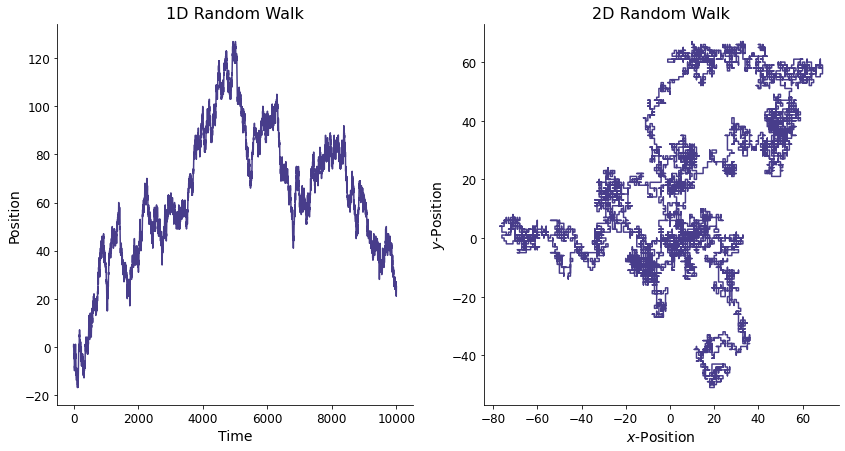

In [5]:
#figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# 1D random walk
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title('1D Random Walk')
ax1.plot(RW_1d, color = 'darkslateblue')

# 2D random walk
ax2.set_xlabel('$x$-Position')
ax2.set_ylabel('$y$-Position')
ax2.set_title('2D Random Walk')
ax2.plot(RW_2d[:,0], RW_2d[:,1], color = 'darkslateblue')

### <span style="color:darkcyan">Exercise 3.3
I define a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin.

In [6]:
def get_num_returns(length, dim) :
    traj = get_traj(length, dim) # generate a RW of given length and dimension
    check = np.all(traj == 0, axis = 1) # count how many times it goes through the origin
    n = 0 # counter
    for i in range(length) :
        if(check[i]) :
            n += 1 # counting procedure
    return n

### <span style="color:darkcyan">Exercise 3.4
I define a function that computes the expected number of returns to the origin for a given length and dimension.

In [7]:
def get_average_num_returns(length, dim, num_trajs):
    sample = [get_num_returns(length, dim) for i in range(num_trajs)]
    return np.average(np.asarray(sample))

### <span style="color:darkcyan">Exercise 3.5
I plot the average number of returns to the origin of a one-dimensional RW as a function of the RW length, together with the fitted expected theoretical result. According to it, one must have that $<T_n>=\sqrt{n}$.

I define the function `get_num_returns_array`, in order to generalize the procedure to an arbitrary number of dimensions. This function generates a RW and counts the average number of returns for a given dimension and a given averaging number. Note that it is better to define such function and not simply copypaste the cell, since one cannot afford to have more lists with the same name because it can lead to ill-defined variables and biased outputs.

In [8]:
def get_num_returns_array(dim, num_trajs, length_array) :
    num_returns_array = np.array([ [
        get_average_num_returns(length, dim, n)
        for length in length_array ]
        for n in num_trajs
    ])
    return num_returns_array

I want to plot the expected number of returns to the origin as a function of the RW length. Since the range of the $N_\text{steps}$ axis is wide, I will use a logarithmic scale; therefore, it is useful to first define an array of RW lengths.

In [9]:
# define range of RW lengths and number of samplings
length_min = 10
length_max = 100000
num = 20

# generate points logarithmically spaces and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num = num) ])
print(length_array)

[    10     16     26     42     69    112    183    297    483    784
   1274   2069   3359   5455   8858  14384  23357  37926  61584 100000]


Note that exercises from 3.5 to 3.7 show the same features. The following code cell runs the simulation: since it takes a non-trivial amount of time, I decided to write the results in an output file, so that one can read the data from file and avoid repeating the simulation.

In [10]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in 1d_scaling.dat
"""
dim = 1
num_trajs = [1, 200, 1000]
num_returns_array = get_num_returns_array(dim, num_trajs, length_array)

# the following line saves data, so that one need not do the simulation again
np.savetxt('1d_scaling.dat', num_returns_array)
"""

"\ndim = 1\nnum_trajs = [1, 200, 1000]\nnum_returns_array = get_num_returns_array(dim, num_trajs, length_array)\n\n# the following line saves data, so that one need not do the simulation again\nnp.savetxt('1d_scaling.dat', num_returns_array)\n"

Here I produce three plots, one for each choice of the value of <code>num_trajs</code>, that is the number of RWs on which I average the output. I fit the numerical data with the following function:

$$f_{m,k}(x) = m x^k$$

where the parameters $m$ and $k$ need to be found. One expects that $m\simeq 1$ and $k\simeq 1/2$.

Fit (With 1 samples): covariance matrix =
 [[ 8.78172200e-03 -5.15408087e-01]
 [-5.15408087e-01  3.12531066e+01]]
Fit (With 200 samples): covariance matrix =
 [[ 8.16542929e-05 -6.83795617e-04]
 [-6.83795617e-04  5.77472703e-03]]
Fit (With 1000 samples): covariance matrix =
 [[ 1.94564555e-05 -1.76019656e-04]
 [-1.76019656e-04  1.60621804e-03]]


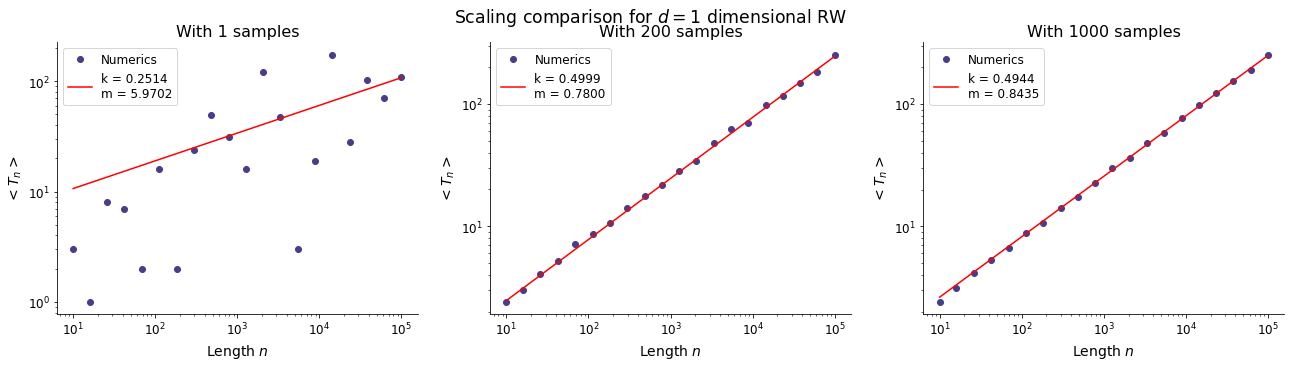

In [11]:
dim = 1
num_trajs = [1, 200, 1000]
num_returns_array = np.loadtxt('data/1d_scaling.dat')
fig = plt.figure(figsize=(22, 5))
fig.suptitle('Scaling comparison for $d=$' + str(dim) + ' dimensional RW' + '\n', fontsize = 'xx-large')
ax = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]
title = ['With ' + str(n) + ' samples' for n in num_trajs]
x = np.arange(length_min, length_max)
f = lambda x, k, m: m * x**k
for i in range(3) :
    ax[i].set_title(title[i])
    ax[i].loglog(length_array, num_returns_array[i], marker = 'o', label = 'Numerics', linestyle = 'None', color = 'darkslateblue') # numerical result
    popt, pcov = curve_fit(f, length_array, num_returns_array[i])
    k = popt[0]
    m = popt[1]
    ax[i].loglog(x, m * x**k, label = f'k = {k:.4f}\nm = {m:.4f}', c = 'red') # plot fit
    print('Fit (' + title[i] + '): ' + f'covariance matrix =\n {pcov}') # print infos
    ax[i].set_xlabel('Length $n$')
    ax[i].set_ylabel('$<T_n>$')
    ax[i].legend()

Observe that my results respect the scaling law. Note that the covariance is reduced by one magnitude order when the average is taken with respect to a bigger dataset: this was also expected. The case with only one sample is, of course, of no interest for the data analysis.

### <span style="color:darkcyan">Exercise 3.6
I plot the average number of returns to the origin of a one-dimensional RW as a function of the RW length, together with the fitted expected theoretical result. According to it, one must have that $<T_n>=\log{n}$.

In [12]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in 2d_scaling.dat
"""
dim = 2
num_trajs = [1, 100, 1000]
num_returns_array = get_num_returns_array(dim, num_trajs, length_array)

# the following line saves data, so that one need not do the simulation again
np.savetxt('2d_scaling.dat', num_returns_array)
"""

"\ndim = 2\nnum_trajs = [1, 100, 1000]\nnum_returns_array = get_num_returns_array(dim, num_trajs, length_array)\n\n# the following line saves data, so that one need not do the simulation again\nnp.savetxt('2d_scaling.dat', num_returns_array)\n"

The three plots produced here show the scaling alongside its fit. The function to be fitted is:

$$f_{k,m}(x)=k\log(mx).$$

Fit (With 1 samples): covariance matrix =
 [[ 0.06611388 -1.3287539 ]
 [-1.3287539  30.58772334]]
Fit (With 100 samples): covariance matrix =
 [[ 2.66662651e-04 -1.90302605e-01]
 [-1.90302605e-01  1.46482044e+02]]
Fit (With 1000 samples): covariance matrix =
 [[ 2.47102247e-05 -7.61368319e-03]
 [-7.61368319e-03  2.55908188e+00]]


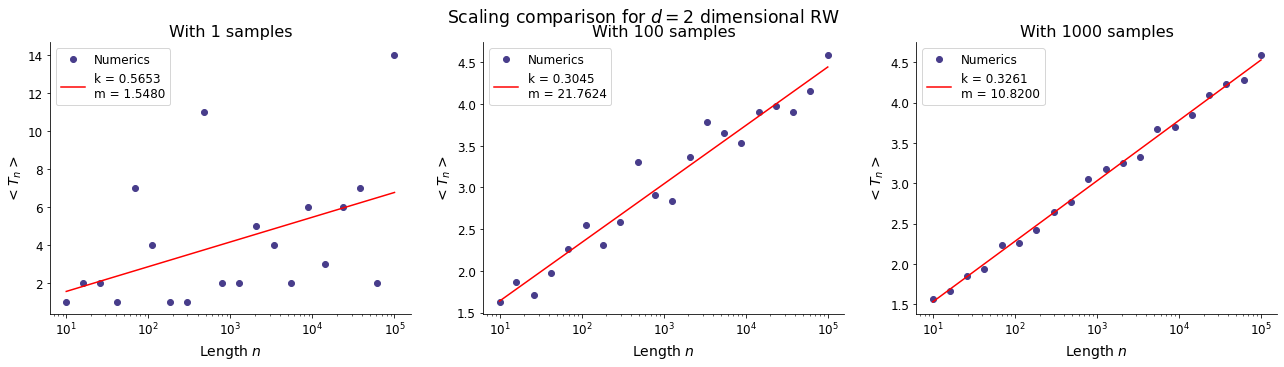

In [13]:
dim = 2
num_trajs = [1, 100, 1000]
num_returns_array = np.loadtxt('data/2d_scaling.dat')
fig = plt.figure(figsize=(22, 5))
fig.suptitle('Scaling comparison for $d=$' + str(dim) + ' dimensional RW', fontsize = 'xx-large')
ax = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]
title = ['With ' + str(n) + ' samples' for n in num_trajs]
x = np.arange(length_min, length_max)
f = lambda x, k, m: k * np.log(m*x) # lambda function to be fitted
for i in range(3) :
    ax[i].set_title(title[i])
    ax[i].semilogx(length_array, num_returns_array[i], marker = 'o', label = 'Numerics', linestyle = 'None', color = 'darkslateblue') # numerical result
#    ax[i].plot(length_array, num_returns_array[i], marker = 'o', label = 'Numerics', linestyle = 'None', color = 'darkslateblue') # numerical result
    popt, pcov = curve_fit(f, length_array, num_returns_array[i])
    k = popt[0]
    m = popt[1]
    sigma = np.sqrt(pcov[0, 0])
    ax[i].semilogx(x, k * np.log(m*x), label = f'k = {k:.4f}\nm = {m:.4f}', c = 'red') # plot fit
#    ax[i].plot(x, k * np.log(x), label = 'Fit', c = 'red') # plot fit
    print('Fit (' + title[i] + '): ' + f'covariance matrix =\n {pcov}') # print infos
    ax[i].set_xlabel('Length $n$')
    ax[i].set_ylabel('$<T_n>$')
    ax[i].legend()

I can conclude that the scaling law is respected by my data. There seems to be a shift of the quantity $k\log(m)$ from the pure $\log(n)$ scaling law that is expected from theoretical considerations. Nonetheless, the function is still logarithmic and the trend of numerical data is clearly verifying to the scaling law.

### <span style="color:darkcyan">Exercise 3.7
I show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is constant.

In [14]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in 3d_scaling.dat
"""
dim = 3
num_trajs = [1, 100, 1000]
num_returns_array = get_num_returns_array(dim, num_trajs, length_array)

# the following line saves data, so that one need not do the simulation again
np.savetxt('3d_scaling.dat', num_returns_array)
"""

"\ndim = 3\nnum_trajs = [1, 100, 1000]\nnum_returns_array = get_num_returns_array(dim, num_trajs, length_array)\n\n# the following line saves data, so that one need not do the simulation again\nnp.savetxt('3d_scaling.dat', num_returns_array)\n"

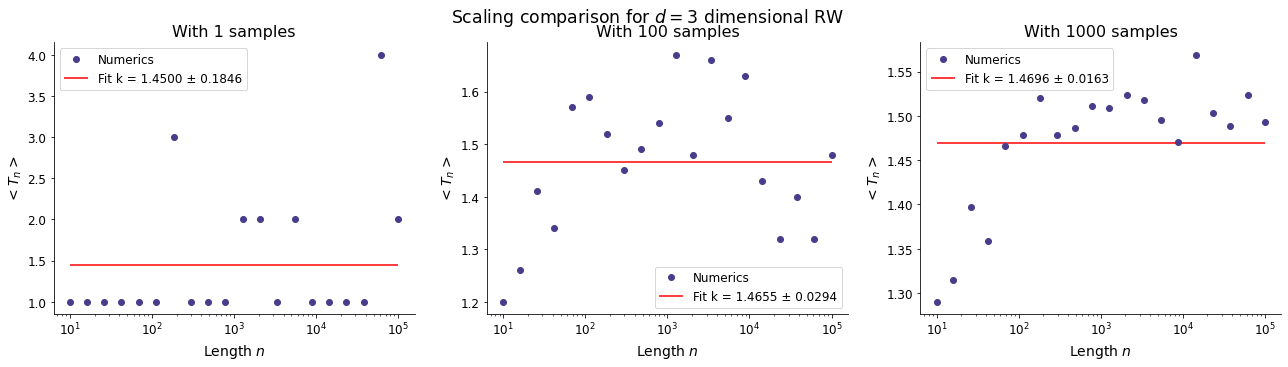

In [15]:
dim = 3
num_trajs = [1, 100, 1000]
num_returns_array = np.loadtxt('data/3d_scaling.dat')
fig = plt.figure(figsize=(22, 5))
fig.suptitle('Scaling comparison for $d=$' + str(dim) + ' dimensional RW', fontsize = 'xx-large')
ax = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]
title = ['With ' + str(n) + ' samples' for n in num_trajs]
x = np.arange(length_min, length_max)
f = lambda x, k: k # lambda function to be fitted
for i in range(3) :
    ax[i].set_title(title[i])
    ax[i].semilogx(length_array, num_returns_array[i], marker = 'o', label = 'Numerics', linestyle = 'None', color = 'darkslateblue') # numerical result
    popt, pcov = curve_fit(f, length_array, num_returns_array[i])
    k = popt[0]
    sigma = np.sqrt(pcov[0, 0])
    ax[i].hlines(k, length_min, length_max, linestyles = 'solid', label = f'Fit k = {k:.4f} ± {sigma:.4f}', color = 'red') # plot fit
    ax[i].set_xlabel('Length $n$')
    ax[i].set_ylabel('$<T_n>$')
    ax[i].legend()

One can conclude that the average number of returns to the origin is constant within the expected fluctuations that come from the fact that we can only sample a finite number of RWs.

Here follows the analysis for $d=4$ dimensions.

In [16]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in 4d_scaling.dat
"""
dim = 4
num_trajs = [1, 100, 1000]
num_returns_array = get_num_returns_array(dim, num_trajs, length_array)

# the following line saves data, so that one need not do the simulation again
np.savetxt('4d_scaling.dat', num_returns_array)
"""

"\ndim = 4\nnum_trajs = [1, 100, 1000]\nnum_returns_array = get_num_returns_array(dim, num_trajs, length_array)\n\n# the following line saves data, so that one need not do the simulation again\nnp.savetxt('4d_scaling.dat', num_returns_array)\n"

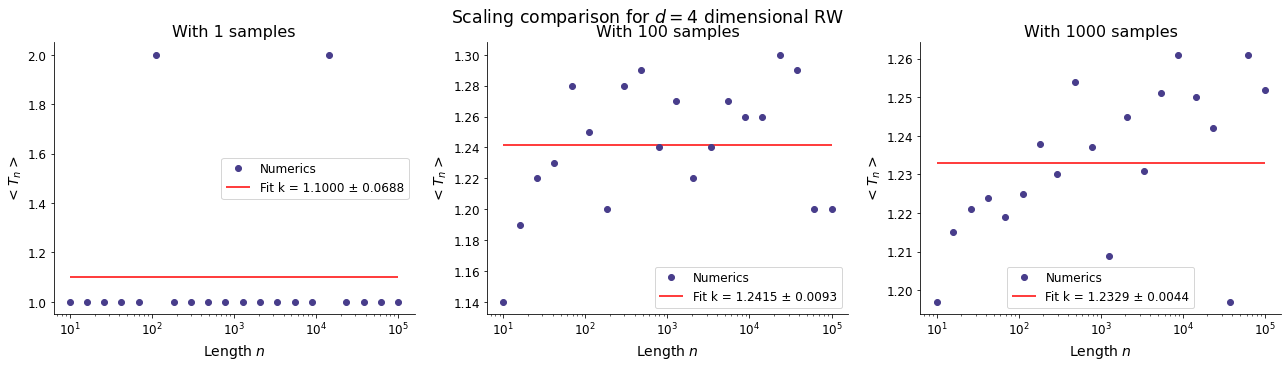

In [17]:
dim = 4
num_trajs = [1, 100, 1000]
num_returns_array = np.loadtxt('data/4d_scaling.dat')
fig = plt.figure(figsize=(22, 5))
fig.suptitle('Scaling comparison for $d=$' + str(dim) + ' dimensional RW', fontsize = 'xx-large')
ax = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]
title = ['With ' + str(n) + ' samples' for n in num_trajs]
x = np.arange(length_min, length_max)
f = lambda x, k: k # lambda function to be fitted
for i in range(3) :
    ax[i].set_title(title[i])
    ax[i].semilogx(length_array, num_returns_array[i], marker = 'o', label = 'Numerics', linestyle = 'None', color = 'darkslateblue') # numerical result
    popt, pcov = curve_fit(f, length_array, num_returns_array[i])
    k = popt[0]
    sigma = np.sqrt(pcov[0, 0])
    ax[i].hlines(k, length_min, length_max, linestyles = 'solid', label = f'Fit k = {k:.4f} ± {sigma:.4f}', color = 'red') # plot fit
    ax[i].set_xlabel('Length $n$')
    ax[i].set_ylabel('$<T_n>$')
    ax[i].legend()

Once again I conclude that the average number of returns to the origin is constant within the expected fluctuations.

## <span style="color:darkslateblue"> Self-Avoiding Walks
Self-avoiding walks ([SAW](https://www.math.ubc.ca/~slade/intelligencer.pdf)) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).
We will implement the [pivot algorithm](https://link.springer.com/article/10.1007/BF01022990), which is simple, effective, and satisfies detailed balance and ergodicity.
Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. Choose a point of $\alpha$ at random, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. Apply a transformation to the tail, leaving the head intact. The transformation must be an orthogonal transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. Check if the new path is self-avoiding. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a Markov chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute expected values as long as it is long enough.

### <span style="color:darkcyan">Exercise 3.8
Write a function `get_traj` that generates a 2D random walk of given length: I can use the function defined at the beginning of the notebook, keeping in mind that the dimension must be 2.

### <span style="color:darkcyan">Exercise 3.9
I define a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Since one wants to rotate the tail of a given RW with respect to the pivot, one must implement the rotation in the following way. Let $(x_0, y_0)$ be the pivot and $(x,y)$ the point to be rotated, then a rotation by the angle $\theta$ produces a new point $(x', y')$ of the form

$$
\begin{pmatrix}
x'\\
y'
\end{pmatrix} = \begin{pmatrix}
\cos\theta&-\sin\theta\\
\sin\theta&\cos\theta
\end{pmatrix}\begin{pmatrix}
x-x_0\\
y-y_0
\end{pmatrix}+\begin{pmatrix}
x_0\\
y_0
\end{pmatrix}
$$

Here follows the code. Notice the presence of a few commented code lines. Their purpose is explained below.

In [18]:
def pivot_traj(traj) :
    
    # choose the pivot
    pivot_index = np.random.randint(0, len(traj))
    pivot_point = traj[pivot_index]
#    print(pivot_index)
    
    # split head and tail
    traj_head = traj[:pivot_index]
    traj_tail = traj[pivot_index:]

    # define the rotation matrices
    symmetries = [
        np.array([[0, -1], [1, 0]]), # 90 deg rotation
        np.array([[-1, 0], [0, -1]]), # 180 deg rotation
        np.array([[0, 1], [-1, 0]]), # 270 deg rotation
    ]
    
    deg = np.random.randint(3)
#    print(deg)
    symmetry = symmetries[deg] # choose one rotation at random
    new_tail = np.asarray(traj_tail)
    new_tail = (new_tail - traj[pivot_index]) @ symmetry + traj[pivot_index]
    
    new_traj = np.concatenate((traj_head, new_tail))
    
    return new_traj

In [19]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in pivot.dat
# current specs: pivot_index = 7260, deg = 0
"""
traj = get_traj(10**4,2)
np.savetxt('traj.dat', traj)
pivot = pivot_traj(traj)
np.savetxt('pivot.dat', pivot)
"""

"\ntraj = get_traj(10**4,2)\nnp.savetxt('traj.dat', traj)\npivot = pivot_traj(traj)\nnp.savetxt('pivot.dat', pivot)\n"

One can see how the algorithm works in the following graphs. Note that, in order to produce the outputs, I have introduced by hand the index of the pivot from the previous simulation. The lines `print(pivot_index)` and `print(deg)` in function `pivot_traj` are now commented.

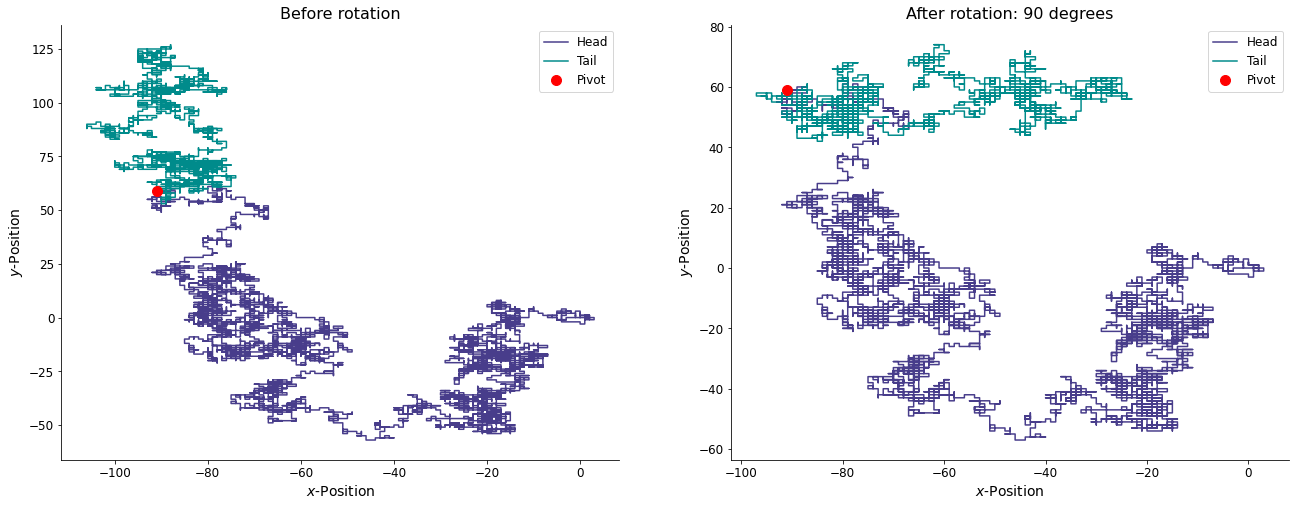

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
pivot = np.loadtxt('data/pivot.dat')
traj = np.loadtxt('data/traj.dat')
n = 7260
deg = 90
    
x = np.array(pivot[n][0])
y = np.array(pivot[n][1])

# before
ax1.set_xlabel('$x$-Position')
ax1.set_ylabel('$y$-Position')
ax1.set_title('Before rotation')
ax1.plot(traj[:n+1, 0], traj[:n+1, 1], label = 'Head', color = 'darkslateblue')
ax1.plot(traj[n:, 0], traj[n:, 1], color = 'darkcyan', label = 'Tail')
ax1.plot(x, y, linestyle = 'None', marker = 'o', color = 'r', label = 'Pivot', markersize = 10)
ax1.legend()

# after
ax2.set_xlabel('$x$-Position')
ax2.set_ylabel('$y$-Position')
ax2.set_title('After rotation: ' + str(deg) + ' degrees')
ax2.plot(pivot[1:n+1, 0], pivot[1:n+1, 1], label = 'Head', color = 'darkslateblue')
ax2.plot(pivot[n:, 0], pivot[n:, 1], color = 'darkcyan', label = 'Tail')
ax2.plot(x, y, linestyle = 'None', marker = 'o', color = 'r', label = 'Pivot', zorder = 2, markersize = 10)
ax2.legend()

### <span style="color:darkcyan">Exercise 3.10
I define a function `count_self_intersections` that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition.

In [21]:
def count_self_intersections(traj) :
    unique, frequency = np.unique(traj, axis = 0, return_counts = True)  
    num_self_intersections = np.sum(frequency) - len(unique)
    return num_self_intersections

### <span style="color:darkcyan">Exercise 3.11
The following cell verifies that `count_self_intersecitons` works properly by using short trajectories for which we know the answer.

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  0.]
 [-1.  0.]
 [-1.  1.]
 [-2.  1.]
 [-2.  0.]
 [-1.  0.]
 [ 0.  0.]
 [-1.  0.]]
Self intersections =  4


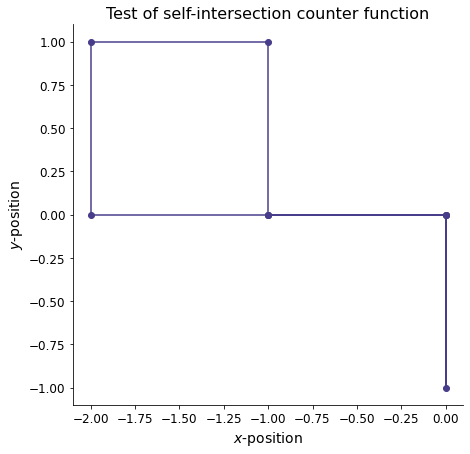

In [22]:
check_traj = get_traj(10, 2)
fig = plt.figure(figsize=(7, 7))
plt.title('Test of self-intersection counter function')
plt.plot(check_traj[:,0], check_traj[:,1], marker = 'o', color = 'darkslateblue')
plt.xlabel('$x$-position')
plt.ylabel('$y$-position')
print(check_traj)
print('Self intersections = ', count_self_intersections(check_traj))

### <span style="color:darkcyan">Exercise 3.12
I define a function `get_first_SAW` that generates a SAW of given length using the following algorithm:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.


In [23]:
def get_first_SAW(length, max_tries):
    traj = get_traj(length, 2)
    tries = 0
    while(count_self_intersections(traj) > 0) :
        new_traj = pivot_traj(traj)
        if(count_self_intersections(new_traj) <= count_self_intersections(traj)) :
            traj = new_traj
        if(tries == max_tries) :
            print('Not able to find a SAW')
            break
        tries += 1
    return traj

### <span style="color:darkcyan">Exercise 3.13
This is a test for the generation function. I plot some 2D SAWs of different lengths.

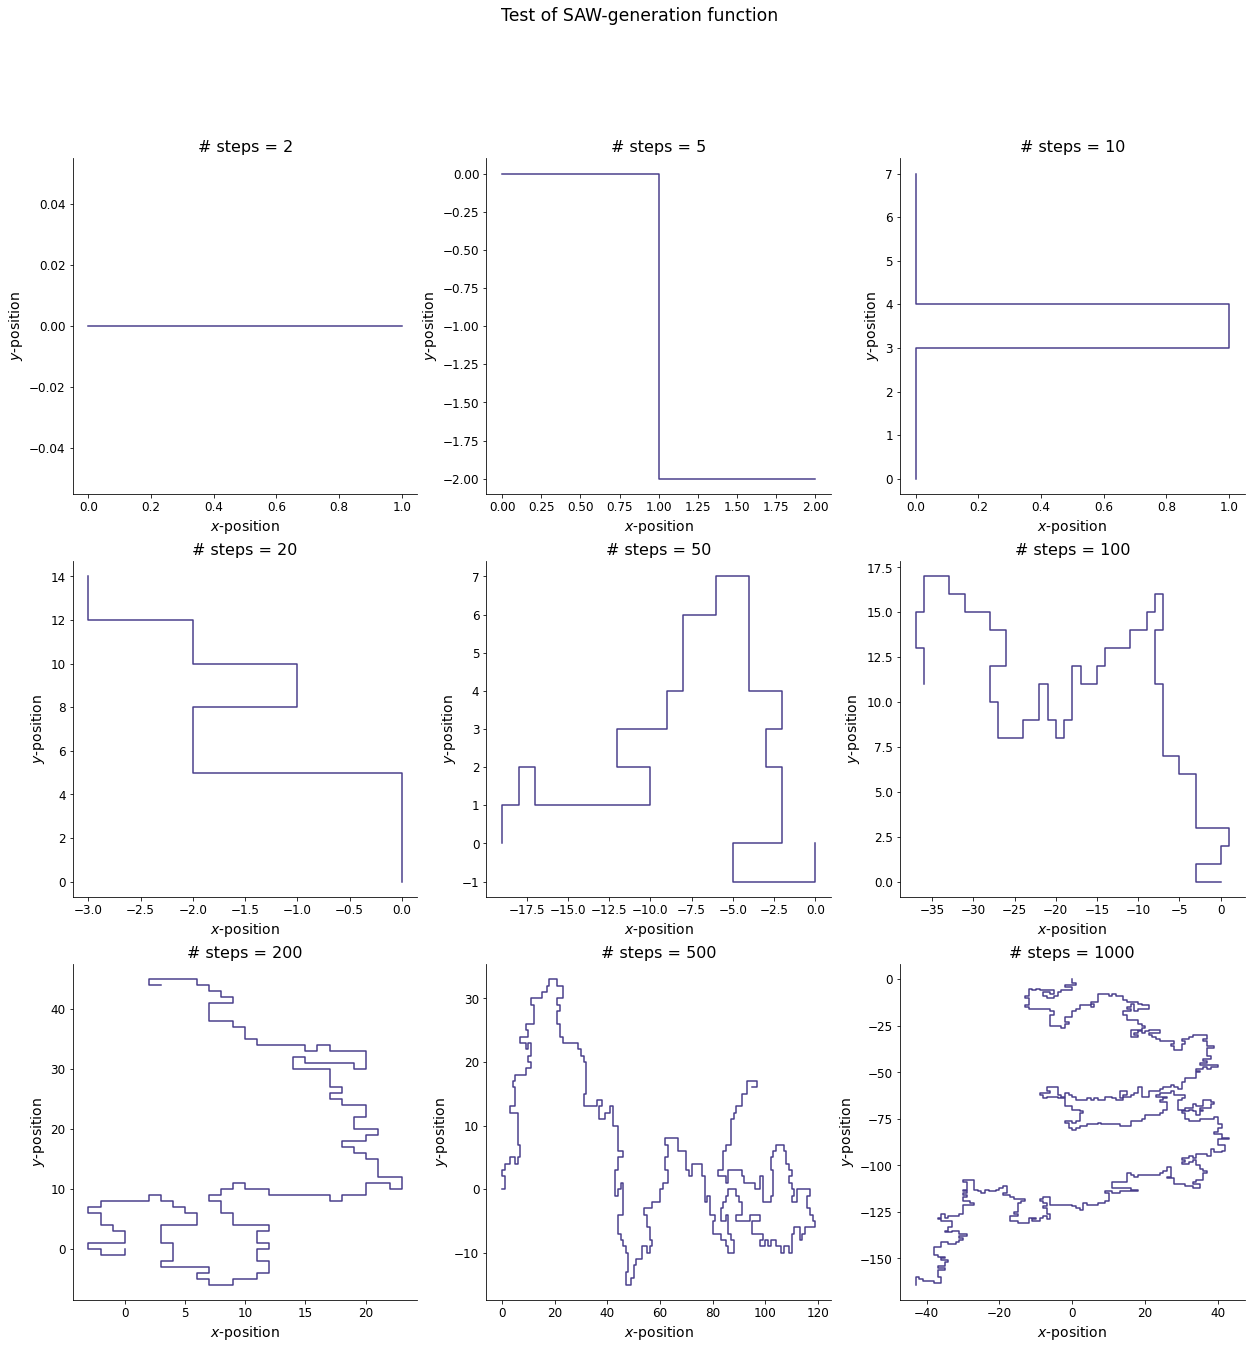

In [24]:
test_lengths = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig = plt.figure(figsize=(21, 21))
fig.suptitle('Test of SAW-generation function', fontsize = 'xx-large')
ax = [plt.subplot(3,3,1), plt.subplot(3,3,2), plt.subplot(3,3,3),
      plt.subplot(3,3,4), plt.subplot(3,3,5), plt.subplot(3,3,6),
      plt.subplot(3,3,7), plt.subplot(3,3,8), plt.subplot(3,3,9)]
title = ['# steps = ' + str(n) for n in test_lengths]
for i in range(len(test_lengths)) :
    RW = get_first_SAW(test_lengths[i], 10**8)
    ax[i].set_title(title[i])
    ax[i].plot(RW[:,0], RW[:,1], color = 'darkslateblue')
    ax[i].set_xlabel('$x$-position')
    ax[i].set_ylabel('$y$-position')

### <span style="color:darkcyan">Exercise 3.14
I define the function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. The function checks that the input RW is really a SAW and implements the following steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. If so, return it. Otherwise, return the original path.

In [25]:
def get_next_SAW(traj):
    assert count_self_intersections(traj) == 0 # check if traj is a SAW
    proposed_traj = pivot_traj(traj) # pivot step
    assert len(proposed_traj) == len(traj)
    num_intersections = count_self_intersections(proposed_traj) # count intersections
    return proposed_traj if(num_intersections == 0) else traj

In [26]:
traj = get_first_SAW(10, 10**8)
for i in range(100) :
    get_next_SAW(traj)

### <span style="color:darkcyan">Exercise 3.15
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

For a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is different! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

Explain why it makes sense that the mean-squared displacement exponent of SAW is greater than that of standard RW. 

Since the random walker moves on a lattice, there is a finite number of nearest neighbors for each site. Furthermore, each site can be visited only once: we should expect that the origin's nearest neighbors are visited after a short amount of steps. If this does not happen, we can be pretty sure that that site will never be visited, since there would be a minimal probability of escaping from it when $N_\text{steps}$ increases (i.e. a large amount of points near the origin has been visited).
From this, we can say that a SAW walker tends to escape from its starting point more than a RW walker and, therefore, its mean square displacement is greater than one of a regular RW.

### <span style="color:darkcyan">Exercise 3.16
I verify numerically the scaling of the mean-squared displacement of SAW following this scheme:

1. Generate a first SAW with your `get_first_SAW()` function.
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required.
4. Compute the average mean-squared displacement of the stored endpoints.

In order to do so, I define the following functions.

In [27]:
# euclidean distance for two point a and b in 2 dimensions
def distance_2d(a, b) :
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

# this function returns the averaged squared distance for N_SAWs of given length
def get_MSD(N_SAWs, length) :
    SAW = get_first_SAW(length, 10**8) # first SAW
    distance = []
    for i in range(N_SAWs) :
        distance = distance + [distance_2d(SAW[length - 1], SAW[0])] # append distances in a list
        SAW = get_next_SAW(SAW) # generate next SAW of the Markov chain
    return np.average(np.asarray(distance)) # list -> array and then average

The following cell simulates the SAWs for relatively small lengths ($\le 20$). Notice that the length of the Markov chain is $10^5$: it must be a big number in order to satisfy detailed balance. Because of this, the simulation takes a non-trivial amount of time and, once again, I prefer to store the data in an output file.

In [28]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in msd.dat
"""
MSD = [get_MSD(10**5, n) for n in range(1, 21)]
np.savetxt('msd.dat', MSD)
"""

"\nMSD = [get_MSD(10**5, n) for n in range(1, 21)]\nnp.savetxt('msd.dat', MSD)\n"

I fit the simulated data with a function $x^k$. One should expect that $k\simeq 3/2$.

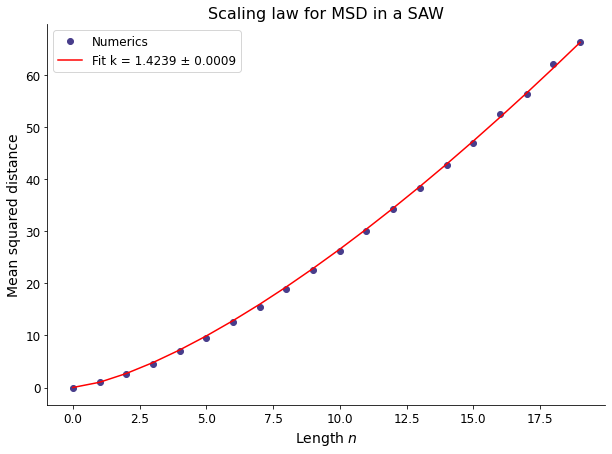

In [29]:
# load data
file = np.loadtxt('data/msd.dat')

# figure specs
fig = plt.figure(figsize=(10, 7))
plt.title('Scaling law for MSD in a SAW')

# plot numerical data
plt.plot(file, marker = 'o', linestyle = 'None', label = 'Numerics', color = 'darkslateblue')

# fitting procedure
f = lambda x, k: x**k # lambda function to be fitted
x = np.arange(20)
popt, pcov = curve_fit(f, x, file)
k = popt[0]
sigma = np.sqrt(pcov[0, 0])
plt.plot(x, x**k, label = f'Fit k = {k:.4f} ± {sigma:.4f}', c = 'red') # plot fit

# legend and axis label
plt.xlabel('Length $n$')
plt.ylabel('Mean squared distance')
plt.legend()

My results seem to confirm the ansatz proposed: the mean squared distance for a SAW scales as $n^k$, with $k\simeq 3/2$.